# 02_model_training.ipynb
## Entraînement & évaluation des modèles P7 (LogReg, DistilBERT)
# 1 - Imports & configuration

In [1]:
import os
import sys
import pandas as pd
import mlflow
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib

In [2]:
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
from src.utils.load_models_from_p7 import load_logreg_model, load_distilbert_model
from src.utils.text_utils import prepare_for_vectorization
from transformers import TextClassificationPipeline
from src.utils.vectorizer_utils import load_tfidf_vectorizer, vectorize_data, train_and_save_tfidf
from src.model_training import train_logreg_pipeline

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Bloc de vérification GPU
from src.utils.device_utils import check_gpu

In [5]:
device = check_gpu()

🔍 Vérification GPU (torch, tensorflow, nvidia-smi)...
✅ torch.cuda : NVIDIA GeForce GTX 1060 6GB (CUDA 11.8)
✅ TensorFlow : /physical_device:GPU:0 (CUDA 64_112, cuDNN 64_8)
✅ nvidia-smi : disponible
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |


# 2 - Chargement des données nettoyées

In [6]:
clean_path = '../data/processed/tweets_cleaned.csv'

df = pd.read_csv(clean_path)
df = df[['label', 'text']]
df.head()

,label,text
0,0,oh no where did u order from thats horrible
1,0,a great hard training weekend is over a couple...
2,0,right off to work only hours to go until im fr...
3,0,i am craving for japanese food
4,0,jean michel jarre concert tomorrow gotta work ...


# 3 - Préparation du jeu de test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size = 0.2, stratify = df['label'], random_state = 70)

# 4 - LogReg + TF-IDF : Prédiction & évaluation

In [8]:
model_dir = "../models/logreg_model"
logreg_model, acc_logreg, f1_logreg = train_logreg_pipeline(
    X_train, y_train,
    X_test, y_test,
    model_dir = model_dir,
    run_name = "logreg_imported",
    force_retrain = False,
    log_to_mlflow = True
)

# 5 - DistilBERT fine-tuné : Prédiction & évaluation

In [9]:
distilbert_model, distilbert_tokenizer = load_distilbert_model("../models_from_P7/distilbert_model")

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✅ Modèle DistilBERT fine-tuné chargé avec succès.


In [10]:
pipeline = TextClassificationPipeline(model = distilbert_model, tokenizer = distilbert_tokenizer, return_all_scores = False, device = 0 if torch.cuda.is_available() else -1)

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 5.1 - Pour accélérer : prédiction sur les 2000 premiers tweets

In [11]:
X_test_cleaned = X_test.fillna("").astype(str)
texts_for_bert = X_test_cleaned.tolist()[:2000]
y_pred_distilbert = [int(pred['label'][-1]) for pred in pipeline(texts_for_bert)]
y_true_short = y_test.iloc[:2000].tolist()

In [12]:
acc_distilbert = accuracy_score(y_true_short, y_pred_distilbert)
f1_distilbert = f1_score(y_true_short, y_pred_distilbert)

In [13]:
print(f"DistilBERT - Accuracy: {acc_distilbert:.4f} | F1-score: {f1_distilbert:.4f}")

DistilBERT - Accuracy: 0.8145 | F1-score: 0.8196


# 6 - Tableau récapitulatif

In [14]:
results_df = pd.DataFrame({
    "Modèle": ["TF-IDF + LogReg", "DistilBERT fine-tuné"],
    "Accuracy": [acc_logreg, acc_distilbert],
    "F1-score": [f1_logreg, f1_distilbert]
})

In [15]:
results_df.to_csv("../results/model_scores_logreg_vs_distilbert.csv", index=False)
results_df

,Modèle,Accuracy,F1-score
0,TF-IDF + LogReg,0.78035,0.783201
1,DistilBERT fine-tuné,0.81450,0.819640


# 7 - Tracking MLflow
## 7.1 - DistilBERT fine-tuné
- TF-IDF + reglog inutile car log déjà dans train_logreg_pipeline

In [16]:
with mlflow.start_run(run_name="distilbert_imported"):
    mlflow.set_tag("source", "imported_from_P7")
    mlflow.log_param("model", "distilbert")
    mlflow.log_param("tokenizer", "distilbert-base-uncased")
    mlflow.log_param("dataset", "tweets_cleaned.csv")
    mlflow.log_metric("accuracy", acc_distilbert)
    mlflow.log_metric("f1_score", f1_distilbert)

# 8 - Visualisations et analyse comparative
## 8.1 - Matrice de confusion (LogReg + DistilBERT)
### 8.1.1 - LogReg

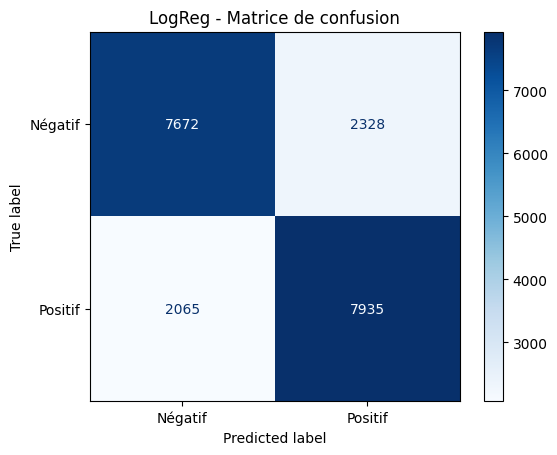

In [17]:
# Chargement du vectoriseur
vectorizer_path = os.path.join(model_dir, "tfidf_vectorizer.joblib")
tfidf_vectorizer = joblib.load(vectorizer_path)

# Vectorisation des données de test
X_test_vec = vectorize_data(tfidf_vectorizer, X_test)

# Prédiction
y_pred_logreg = logreg_model.predict(X_test_vec)

# Matrice de confusion
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix = cm_logreg, display_labels = ["Négatif", "Positif"])
disp_logreg.plot(cmap = 'Blues')
plt.title("LogReg - Matrice de confusion")
plt.show()

### 8.1.2 - DistilBERT

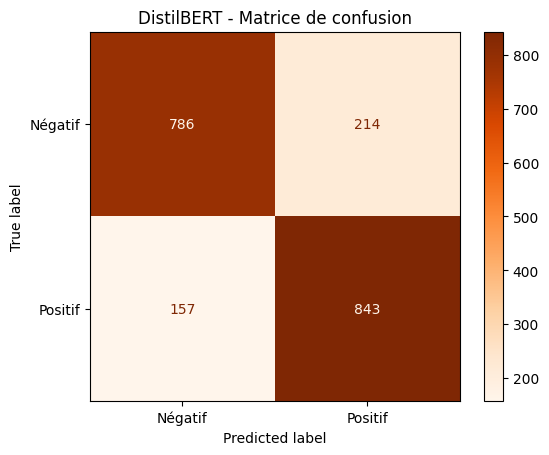

In [18]:
cm_distilbert = confusion_matrix(y_true_short, y_pred_distilbert)
disp_distilbert = ConfusionMatrixDisplay(confusion_matrix=cm_distilbert, display_labels=["Négatif", "Positif"])
disp_distilbert.plot(cmap='Oranges')
plt.title("DistilBERT - Matrice de confusion")
plt.show()

## 8.2 - Courbe barplot comparative Accuracy / F1

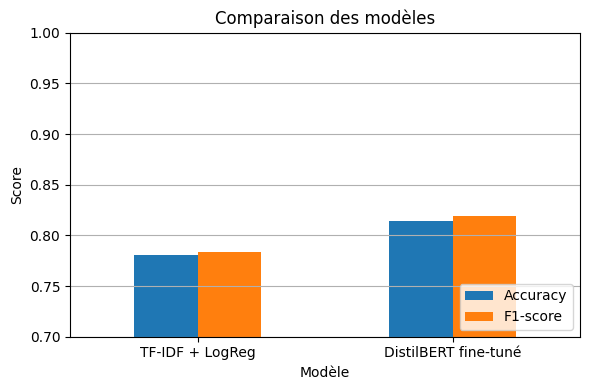

In [19]:
results_df.plot(x="Modèle", kind="bar", rot=0, figsize=(6, 4))
plt.title("Comparaison des modèles")
plt.ylim(0.7, 1)
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 8.3 - Description des résultats
- Récapitulatif :
    - TF-IDF + LogReg : Accuracy = {acc_logreg:.4f}, F1-score = {f1_logreg:.4f}
    - DistilBERT      : Accuracy = {acc_distilbert:.4f}, F1-score = {f1_distilbert:.4f}
- DistilBERT offre de meilleures performances, mais au prix d’un poids plus élevé et d’une latence accrue.
- LogReg reste plus léger et parfaitement déployable sur CPU, ce qui en fait une bonne baseline.
## 8.4 - Sauvegarde des prédictions

In [20]:
pd.DataFrame({
    "tweet": X_test.iloc[:2000].values,
    "true_label": y_true_short,
    "pred_distilbert": y_pred_distilbert
}).to_csv("../results/distilbert_predictions_sample.csv", index=False)